**In this notebook, we will use 1D Convolution to develop a time series forecasting model**

In [ ]:
from __future__ import print_function

import os
import sys
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

from datetime import datetime

In [1]:
gas_well_df = pd.read_csv('../dat/input_gas_well.csv')
print('Shape of the dataframe:', gas_well_df.shape)

def parse(x):
    date_conv = datetime.fromtimestamp(x/1000.0)
    return date_conv.strftime('%d-%m-%Y-%H-%M-%S')

gas_well_df = pd.read_csv('../dat/input_gas_well.csv')
gas_well_df['date'] = gas_well_df['Timestamp'].apply(lambda x : parse(x))

gas_well_df.drop('Timestamp', axis=1, inplace=True)
#gas_well_df = gas_well_df.set_index('date')
gas_well_df['date'] = pd.to_datetime(gas_well_df['date'], format='%d-%m-%Y-%H-%M-%S')
gas_well_df.sort_values('date', ascending=True, inplace=True)

gas_well_df.head(3)

Shape of the dataframe: (2243, 14)


,Gas Meter Temperature_x,Line Pressure_x,Position_x,Tubing Pressure_x,Reservoir Pressure_x,Gas Meter Flow Rate_x,Gas Meter Temperature_y,Line Pressure_y,Position_y,Tubing Pressure_y,Reservoir Pressure_y,Gas Meter Flow Rate_y,Junction pressure,date
0,98.02,527.06,54.16,733.78,1233.97736,16260.90,90.40,521.95,46.23,835.08,1719.674289,15223.68,494.238609,2023-03-26 00:07:00
1,98.16,528.75,54.02,732.94,1233.97736,16132.45,90.47,522.19,45.44,834.61,1719.674289,15195.81,495.408491,2023-03-26 00:17:00
2,98.10,527.91,54.16,730.69,1233.97736,16203.42,90.32,523.24,45.68,836.02,1719.674289,15296.72,495.222547,2023-03-26 00:27:00


Text(0.5, 1.0, 'Box plot of Gas Meter Flow Rate')

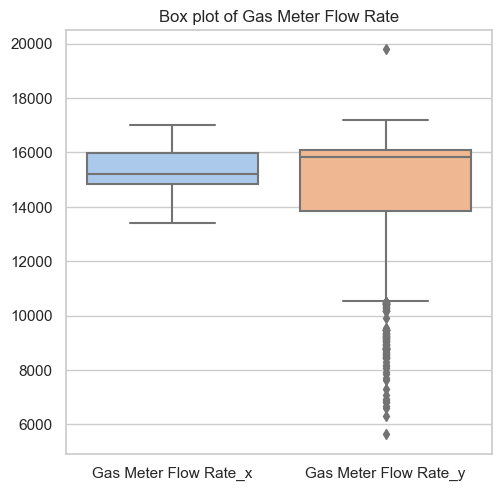

In [2]:
#Let us draw a box plot to visualize the central tendency and dispersion of gas flow rate
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(gas_well_df[['Gas Meter Flow Rate_x','Gas Meter Flow Rate_y']])
g.set_title('Box plot of Gas Meter Flow Rate')

Text(0, 0.5, 'Gas Flow Rate')

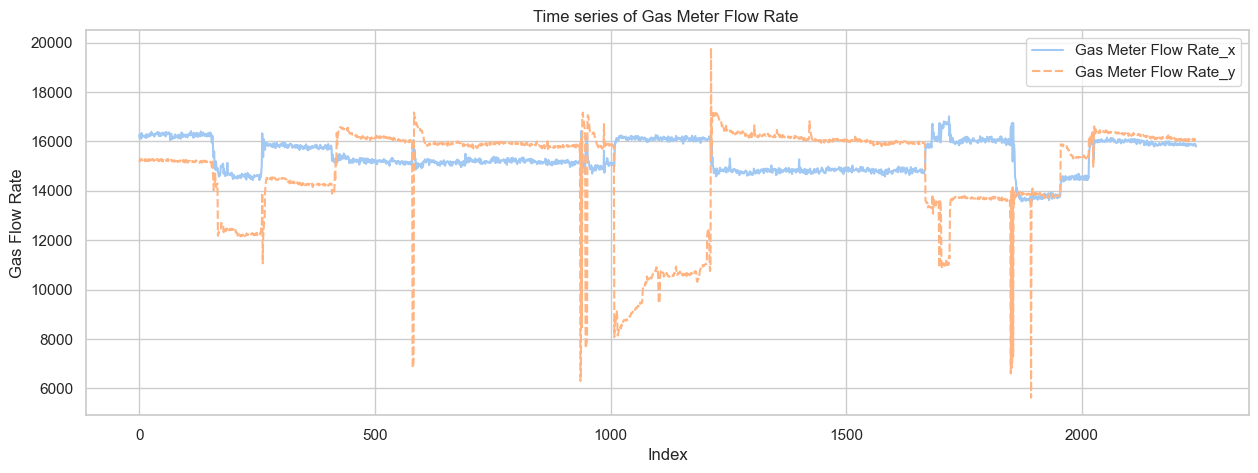

In [3]:
plt.figure(figsize=(15, 5))
g = sns.lineplot(gas_well_df[['Gas Meter Flow Rate_x', 'Gas Meter Flow Rate_y']])
g.set_title('Time series of Gas Meter Flow Rate ')
g.set_xlabel('Index')
g.set_ylabel('Gas Flow Rate')

**Separate the Gas Well X and Gas Well Y dataframes**

In [4]:
col_x, col_y, = list(), list()

for col in gas_well_df.columns:
   if '_x' in col:
     col_x.append(col)
   elif '_y' in col:
      col_y.append(col)

other_columns = ['Junction pressure', 'date', 'year','month', 'day', 'hour', 'minute']

# Separate well x and y columns
gas_well_df_A = gas_well_df.drop(columns=col_y, axis=1)
gas_well_df_B = gas_well_df.drop(columns=col_x, axis=1)

# Reorder columns
gas_well_df_A = gas_well_df_A.iloc[:, [7, 0, 1, 2, 3, 4, 6, 5]]
gas_well_df_B = gas_well_df_B.iloc[:, [7, 0, 1, 2, 3, 4, 6, 5]]

## Modelling for GAS WELL A

**Scaling the predicted variable**

Gradient descent algorithms perform better (for example converge faster) if the variables are wihtin range [-1, 1]. The Gas Meter Flow Rate_x variable is minmax scaled as shown in the following cell in order to bound the scaled features within [0, 1].

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
gas_well_df_A['scaled_gas_mtr_flow_x'] = scaler.fit_transform(np.array(gas_well_df_A['Gas Meter Flow Rate_x']).reshape(-1, 1))

**Train set and validation set split**

- Before training the model, the dataset is split in two parts - train set and validation set. 

- The neural network is trained on the train set. This means computation of the loss function, back propagation and weights updated by a gradient descent algorithm is done on the train set. 

- The validation set is used to evaluate the model and to determine the number of epochs in model training. Increasing the number of epochs will further decrease the loss function on the train set but might not neccesarily have the same effect for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping a tap on the loss function computed for the validation set. 

- We use Keras with Tensorflow backend to define and train the model. All the steps involved in model training and validation is done by calling appropriate functions of the Keras API.

In [6]:
"""
Let's start by splitting the dataset into train and validation. The dataset's time period if from
2023-03-26 to 2023-04-12. It means total 18 days worth of data we have, we can use 12 days for training and 6 days for test
2023-04-07 onwards is kept for validation.

"""
split_date = '2023-04-07 00:07:00'

df_train_A = gas_well_df_A.loc[gas_well_df_A['date']<split_date]
df_val_A = gas_well_df_A.loc[gas_well_df_A['date']>=split_date]

print('Shape of train:', df_train_A.shape)
print('Shape of test:', df_val_A.shape)

# Reset the indices of the validation set. Now, indxe number will start from 0, rather 1668 onwards.
df_val_A.reset_index(drop=True, inplace=True) 

Shape of train: (1668, 9)
Shape of test: (575, 9)


**Plot the standardized gas meter flow**

Text(0, 0.5, 'Scaled Gas Flow Rate readings')

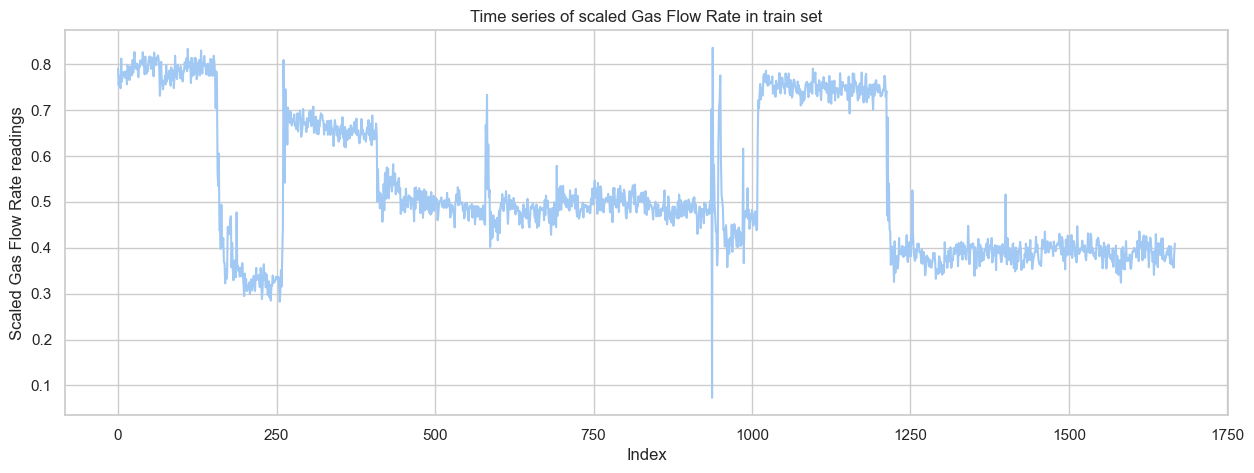

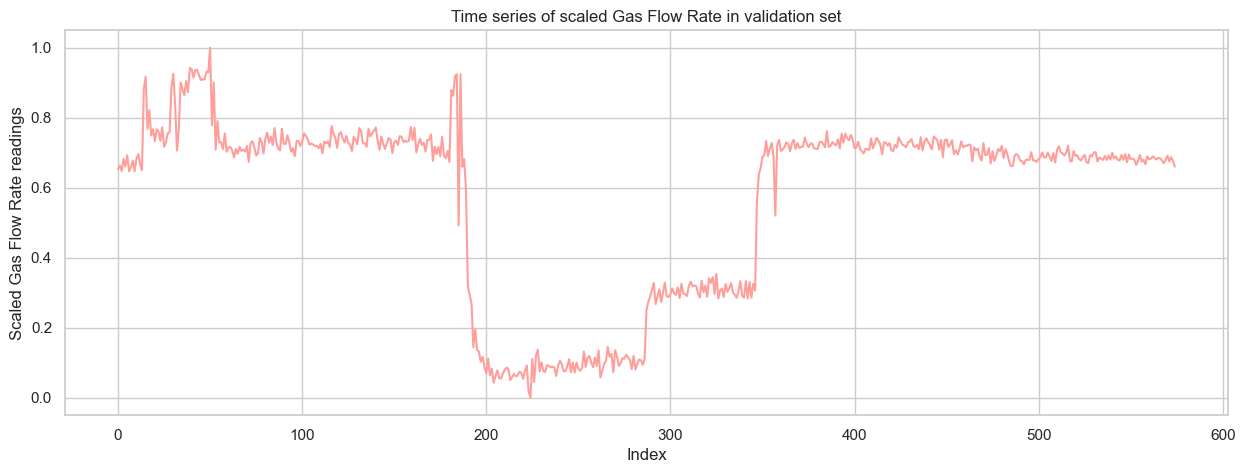

In [7]:
"""
The train and validation time series of standardized Gas Flow Rate is also plotted.
"""

plt.figure(figsize=(15, 5))
g = sns.lineplot(df_train_A['scaled_gas_mtr_flow_x'], color='b')
g.set_title('Time series of scaled Gas Flow Rate in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Gas Flow Rate readings')

plt.figure(figsize=(15, 5))
g = sns.lineplot(df_val_A['scaled_gas_mtr_flow_x'], color='r')
g.set_title('Time series of scaled Gas Flow Rate in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Gas Flow Rate readings')

**Preparation of data as Regressor and Target**

Now we need to generate regressors (X) and target variable (y) for train and validation. 

- 2-D array of regressor and 1-D array of target is created from the original 1-D array of columm scaled_gas_mtr_flow_x in the DataFrames. 

- For the time series forecasting model, Past seven data points of observations are used to predict for the next data point. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.


In [8]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y


X_train_A, y_train_A = makeXy(df_train_A['scaled_gas_mtr_flow_x'], 7)
print('Shape of train arrays:', X_train_A.shape, y_train_A.shape)

X_val_A, y_val_A = makeXy(df_val_A['scaled_gas_mtr_flow_x'], 7)
print('Shape of validation arrays:', X_val_A.shape, y_val_A.shape)

Shape of train arrays: (1661, 7) (1661,)
Shape of validation arrays: (568, 7) (568,)


**Reshaping input to RNN in [number_of_sample, number_of_timesteps, number_of_features/per timestep]**

Number of timesteps is seven and number of samples is same as the number of samples in X_train and X_val, which are reshaped to 3D arrays. Number of feature is 1 



In [9]:
X_train_A, X_val_A = X_train_A.reshape((X_train_A.shape[0], X_train_A.shape[1], 1)), \
                     X_val_A.reshape((X_val_A.shape[0], X_val_A.shape[1], 1))
print('Shape of 3D arrays:', X_train_A.shape, X_val_A.shape)

Shape of 3D arrays: (1661, 7, 1) (568, 7, 1)


**Building Model**

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making predictions. Mean square error (mse) is used as the loss function.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, adam uses different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.


In [10]:
from keras.layers import Dense, Input, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32')

#LSTM layer is defined for seven timesteps
bilstm_layer_1 = Bidirectional(LSTM(64, input_shape=(7,1), activation='relu', return_sequences=True))(input_layer)
bilstm_layer_2 = Bidirectional(LSTM(32, input_shape=(7,1), activation='relu', return_sequences=False))(bilstm_layer_1)

dropout_layer = Dropout(0.1)(bilstm_layer_2)

#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='relu')(dropout_layer)

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mae', optimizer='adam')
ts_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 7, 128)           33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 75,073
Trainable params: 75,073
Non-trainable p

In [11]:
"""
The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. 

A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.
"""
save_weights = os.path.join('BiLSTM_Model', 'Gas_Flow_Rate_x.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)

ts_model.fit(x=X_train_A, y=y_train_A, batch_size=16, epochs=20,
             verbose=0, callbacks=[save_best], validation_data=(X_val_A, y_val_A),
             shuffle=True)

2023-05-13 08:00:53.251854: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


**Prediction on Validation Set**

Prediction are made for the gas flow rate from the best saved model. 

The model's predictions, which are on the minmax scaled gas flow rate, are inverse transformed to get predictions on gas flow rate. 

The goodness-of-fit, R-squared is also calculated for the predictions on the original variable.


18/18 [==============================] - 0s 4ms/step
R-squared on validation set of the original gas flow meter rate: 0.9311392187067588


Text(0.5, 0, 'Index')

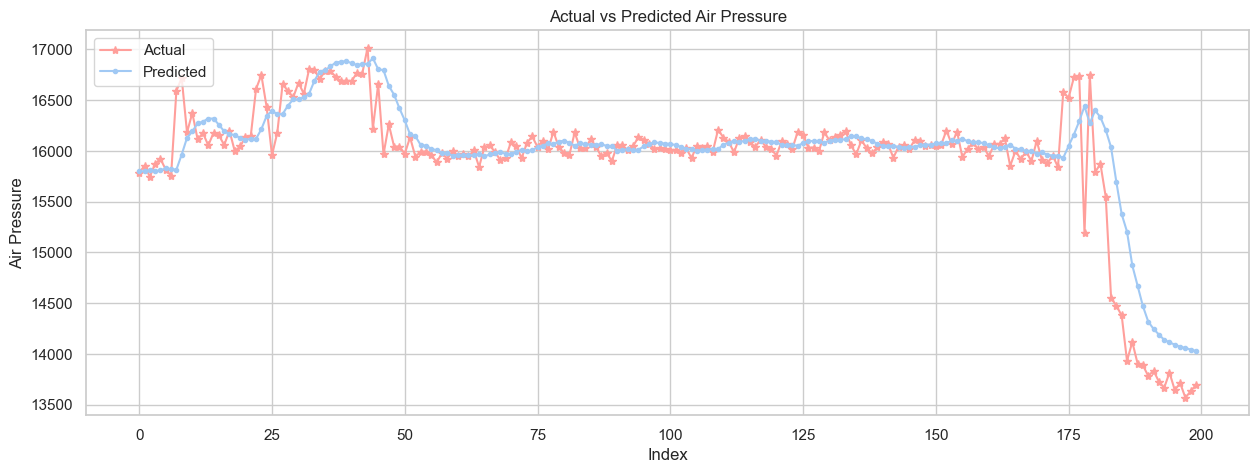

In [12]:
from sklearn.metrics import r2_score

best_model = load_model(os.path.join('BiLSTM_Model', 'Gas_Flow_Rate_x.10-0.0400.hdf5'))
preds = best_model.predict(X_val_A)
pred_gas_flow_x = scaler.inverse_transform(preds)
pred_gas_flow_x = np.squeeze(pred_gas_flow_x)

r2 = r2_score(df_val_A['Gas Meter Flow Rate_x'].loc[7:], pred_gas_flow_x)
print('R-squared on validation set of the original gas flow meter rate:', r2)

df_val_A['pred_gas_flow_x'] = pd.Series(pred_gas_flow_x)

#Let's plot the first 200 actual and predicted values of gas flow rate
plt.figure(figsize=(15, 5))
plt.plot(range(200), df_val_A['Gas Meter Flow Rate_x'].loc[7:206], linestyle='-', marker='*', color='r')
plt.plot(range(200), pred_gas_flow_x[:200], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

In [13]:
# calculate RMSE
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(df_val_A['Gas Meter Flow Rate_x'].loc[7:], pred_gas_flow_x))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 242.519


**Adding for train set for final integration**

52/52 [==============================] - 0s 3ms/step
R-squared on validation set of the original air pressure: 0.9281007965440029


Text(0.5, 0, 'Index')

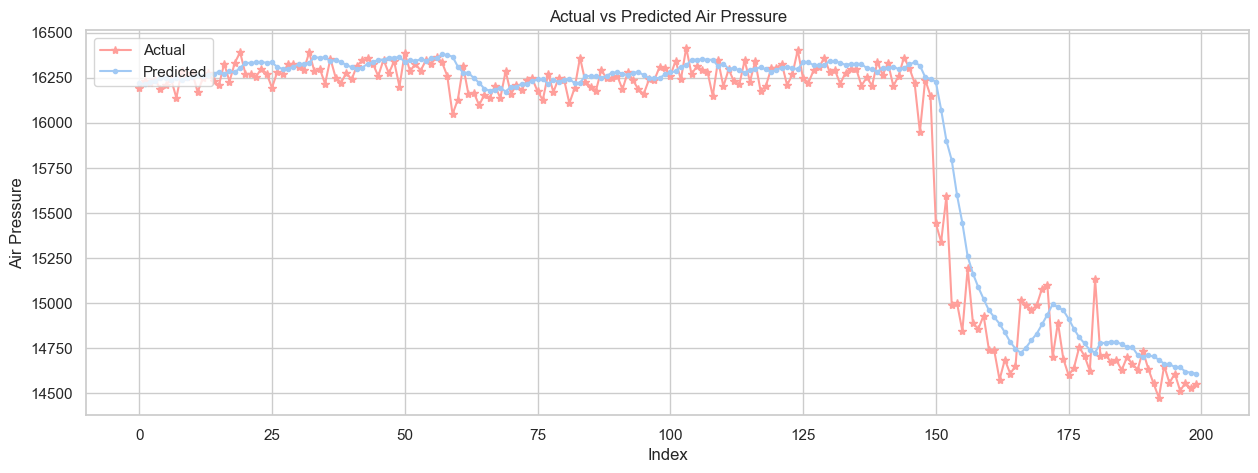

In [14]:
preds = best_model.predict(X_train_A)
pred_gas_flow_x = scaler.inverse_transform(preds)
pred_gas_flow_x = np.squeeze(pred_gas_flow_x)

r2 = r2_score(df_train_A['Gas Meter Flow Rate_x'].loc[7:], pred_gas_flow_x)
print('R-squared on validation set of the original air pressure:', r2)

df_train_A['pred_gas_flow_x'] = pd.Series(pred_gas_flow_x)

#Let's plot the first 200 actual and predicted values of gas flow rate
plt.figure(figsize=(15, 5))
plt.plot(range(200), df_train_A['Gas Meter Flow Rate_x'].loc[7:206], linestyle='-', marker='*', color='r')
plt.plot(range(200), pred_gas_flow_x[:200], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

**Integrate output to the dataframe**

In [15]:
df_final_A = pd.concat([df_train_A, df_val_A])
df_final_A.shape

(2243, 10)

## Modelling for GAS WELL B

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
gas_well_df_B['scaled_gas_mtr_flow_y'] = scaler.fit_transform(np.array(gas_well_df_B['Gas Meter Flow Rate_y']).reshape(-1, 1))

In [17]:
"""
Let's start by splitting the dataset into train and validation. The dataset's time period if from
2023-03-26 to 2023-04-12. It means total 18 days worth of data we have, we can use 12 days for training and 6 days for test
2023-04-07 onwards is kept for validation.

"""
split_date = '2023-04-07 00:07:00'

df_train_B = gas_well_df_B.loc[gas_well_df_B['date']<split_date]
df_val_B = gas_well_df_B.loc[gas_well_df_B['date']>=split_date]

print('Shape of train:', df_train_B.shape)
print('Shape of test:', df_val_B.shape)

# Reset the indices of the validation set. Now, indxe number will start from 0, rather 1668 onwards.
df_val_B.reset_index(drop=True, inplace=True) 

Shape of train: (1668, 9)
Shape of test: (575, 9)


Text(0, 0.5, 'Scaled Gas Flow Rate readings')

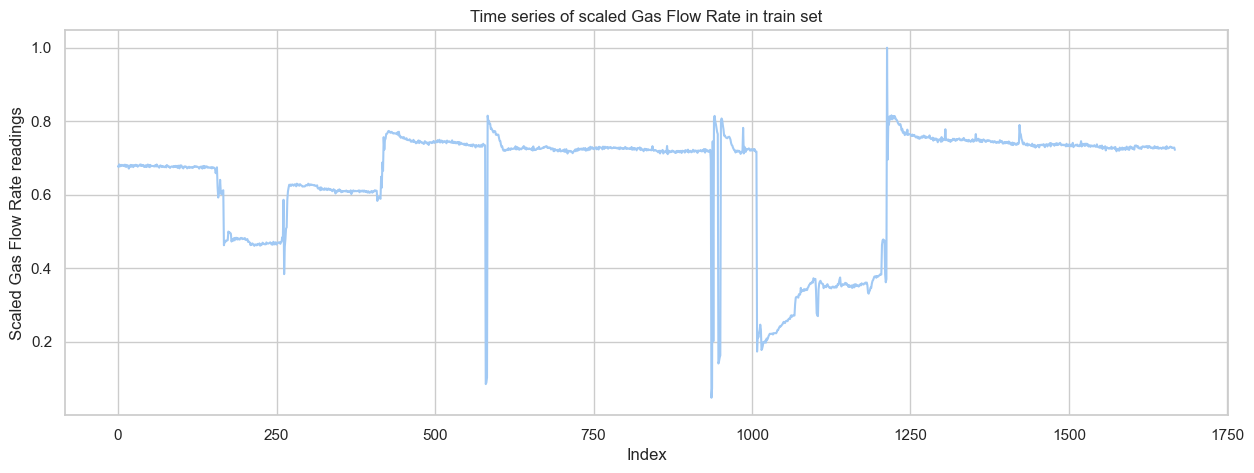

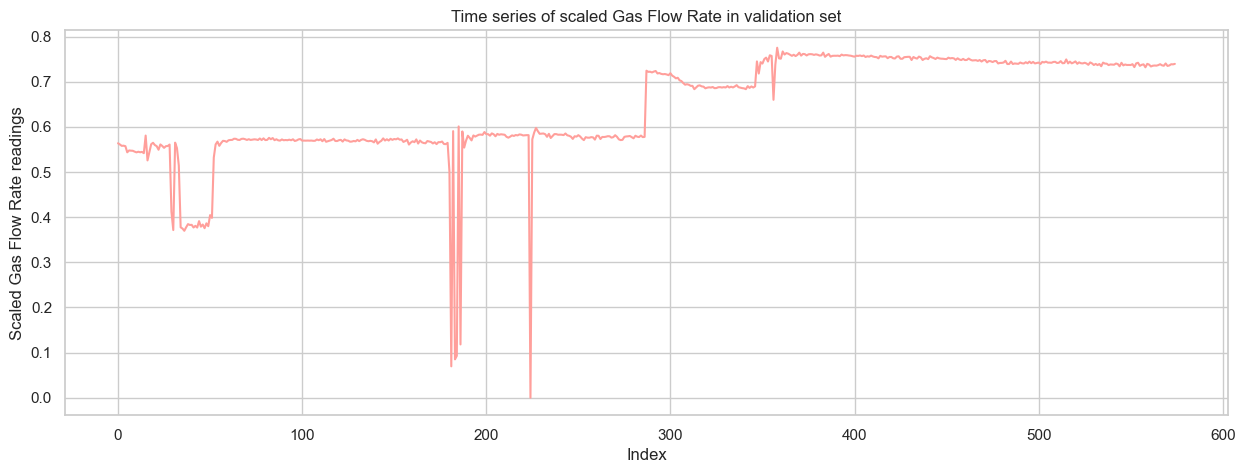

In [18]:
"""
The train and validation time series of standardized Gas Flow Rate is also plotted.
"""

plt.figure(figsize=(15, 5))
g = sns.lineplot(df_train_B['scaled_gas_mtr_flow_y'], color='b')
g.set_title('Time series of scaled Gas Flow Rate in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Gas Flow Rate readings')

plt.figure(figsize=(15, 5))
g = sns.lineplot(df_val_B['scaled_gas_mtr_flow_y'], color='r')
g.set_title('Time series of scaled Gas Flow Rate in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Gas Flow Rate readings')


In [19]:
X_train_B, y_train_B = makeXy(df_train_B['scaled_gas_mtr_flow_y'], 7)
print('Shape of train arrays:', X_train_A.shape, y_train_A.shape)

X_val_B, y_val_B = makeXy(df_val_B['scaled_gas_mtr_flow_y'], 7)
print('Shape of validation arrays:', X_val_B.shape, y_val_B.shape)

Shape of train arrays: (1661, 7, 1) (1661,)
Shape of validation arrays: (568, 7) (568,)


In [20]:
X_train_B, X_val_B = X_train_B.reshape((X_train_B.shape[0], X_train_B.shape[1], 1)), X_val_B.reshape((X_val_B.shape[0], X_val_B.shape[1], 1))
print('Shape of 3D arrays:', X_train_B.shape, X_val_B.shape)

Shape of 3D arrays: (1661, 7, 1) (568, 7, 1)


In [21]:
"""
The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. 

A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.
"""
save_weights = os.path.join('BiLSTM_Model', 'Gas_Flow_Rate_y.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)

ts_model.fit(x=X_train_B, y=y_train_B, batch_size=16, epochs=20,
             verbose=0, callbacks=[save_best], validation_data=(X_val_B, y_val_B),
             shuffle=True)

18/18 [==============================] - 0s 4ms/step
R-squared on validation set of the original gas flow meter rate: 0.8025743577821798


Text(0.5, 0, 'Index')

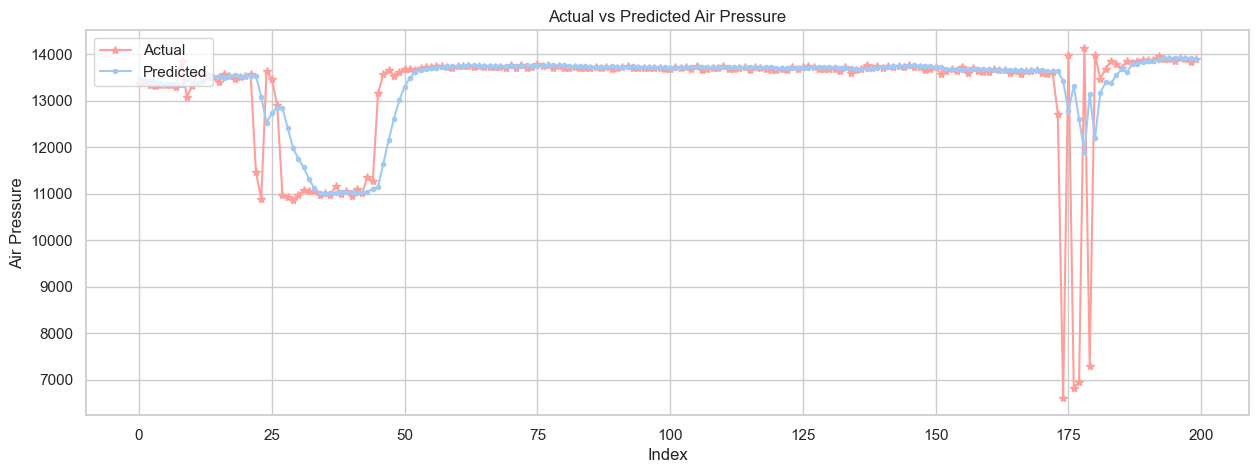

In [23]:
from sklearn.metrics import r2_score

best_model = load_model(os.path.join('BiLSTM_Model', 'Gas_Flow_Rate_y.10-0.0116.hdf5'))
preds = best_model.predict(X_val_B)
pred_gas_flow_y = scaler.inverse_transform(preds)
pred_gas_flow_y = np.squeeze(pred_gas_flow_y)

r2 = r2_score(df_val_B['Gas Meter Flow Rate_y'].loc[7:], pred_gas_flow_y)
print('R-squared on validation set of the original gas flow meter rate:', r2)

df_val_B['pred_gas_flow_y'] = pd.Series(pred_gas_flow_y)

#Let's plot the first 200 actual and predicted values of gas flow rate
plt.figure(figsize=(15, 5))
plt.plot(range(200), df_val_B['Gas Meter Flow Rate_y'].loc[7:206], linestyle='-', marker='*', color='r')
plt.plot(range(200), pred_gas_flow_y[:200], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

In [24]:
rmse = math.sqrt(mean_squared_error(df_val_B['Gas Meter Flow Rate_y'].loc[7:], pred_gas_flow_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 699.971


52/52 [==============================] - 0s 2ms/step
R-squared on validation set of the original air pressure: 0.8792123079853214


Text(0.5, 0, 'Index')

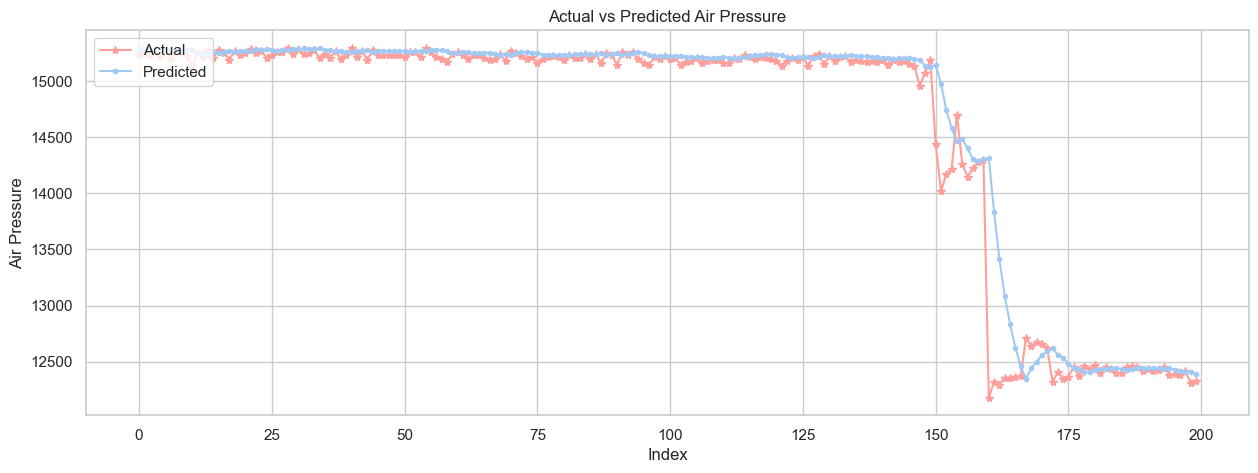

In [25]:
preds = best_model.predict(X_train_B)
pred_gas_flow_y = scaler.inverse_transform(preds)
pred_gas_flow_y = np.squeeze(pred_gas_flow_y)

r2 = r2_score(df_train_B['Gas Meter Flow Rate_y'].loc[7:], pred_gas_flow_y)
print('R-squared on validation set of the original air pressure:', r2)

df_train_B['pred_gas_flow_y'] = pd.Series(pred_gas_flow_y)

#Let's plot the first 200 actual and predicted values of gas flow rate
plt.figure(figsize=(15, 5))
plt.plot(range(200), df_train_B['Gas Meter Flow Rate_y'].loc[7:206], linestyle='-', marker='*', color='r')
plt.plot(range(200), pred_gas_flow_y[:200], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

In [26]:
df_final_B = pd.concat([df_train_B, df_val_B])
df_final_B.shape

(2243, 10)

## Combined Gas Flow Rate and Choke Position

In [27]:
combined_gas_flow_df = pd.merge(df_final_A, df_final_B, on=['date','Junction pressure'], how='inner')

combined_gas_flow_df['actual_combined_gas_flow'] = combined_gas_flow_df['Gas Meter Flow Rate_x'] + combined_gas_flow_df['Gas Meter Flow Rate_y']
combined_gas_flow_df['pred_combined_gas_flow'] = combined_gas_flow_df['pred_gas_flow_x'] + combined_gas_flow_df['pred_gas_flow_y']

In [28]:
combined_gas_flow_df =  combined_gas_flow_df[['date','Position_x', 'Position_y',
                       'Gas Meter Flow Rate_x', 'Gas Meter Flow Rate_y', 'actual_combined_gas_flow',
                       'pred_gas_flow_x', 'pred_gas_flow_y', 'pred_combined_gas_flow']]

Text(0.5, 0, 'Index')

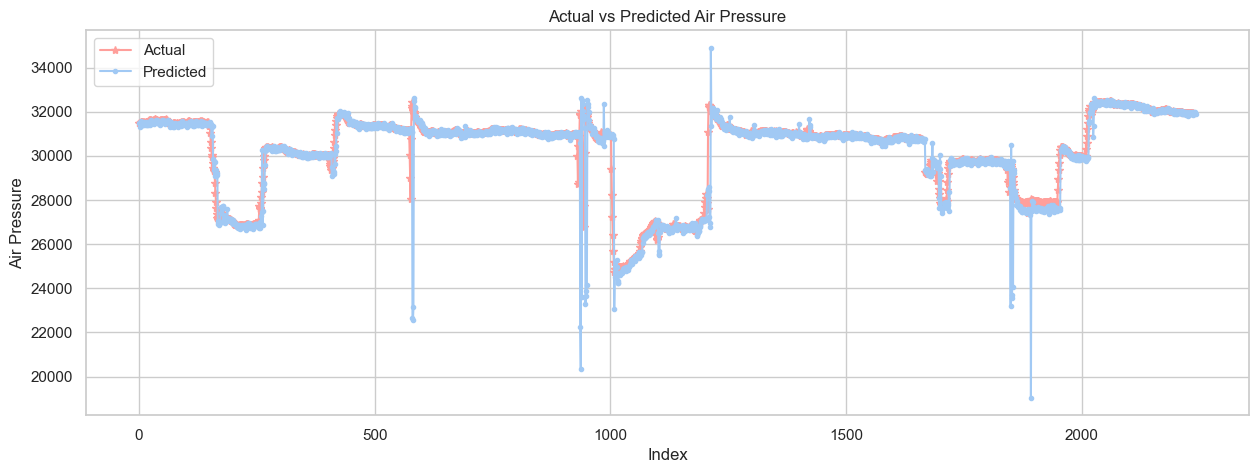

In [29]:
#Let's plot the first 200 actual and predicted values of gas flow rate
plt.figure(figsize=(15, 5))
plt.plot(combined_gas_flow_df['pred_combined_gas_flow'], linestyle='-', marker='*', color='r')
plt.plot(combined_gas_flow_df['actual_combined_gas_flow'], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

In [30]:
combined_gas_flow_df.head()

,date,Position_x,Position_y,Gas Meter Flow Rate_x,Gas Meter Flow Rate_y,actual_combined_gas_flow,pred_gas_flow_x,pred_gas_flow_y,pred_combined_gas_flow
0,2023-03-26 00:07:00,54.16,46.23,16260.90,15223.68,31484.58,16218.160156,15280.956055,31499.117188
1,2023-03-26 00:17:00,54.02,45.44,16132.45,15195.81,31328.26,16213.015625,15280.717773,31493.734375
2,2023-03-26 00:27:00,54.16,45.68,16203.42,15296.72,31500.14,16227.371094,15281.655273,31509.027344
3,2023-03-26 00:37:00,52.49,45.61,16142.20,15244.48,31386.68,16232.941406,15275.104492,31508.046875
4,2023-03-26 00:47:00,53.80,46.29,16107.08,15224.02,31331.10,16246.054688,15283.861328,31529.916016
